# Clustering Penguins: An Introduction to K-Means

add penguins huddling

**Objective:** So far, we have been doing "supervised learning", where the dataset is labelled. In other words, we know the right answer to the prediction. However, there are machine learning algorithms that can find patterns in unlabelled data to develop groups that can then be assigned labels. This is called "unsupervised learning".

A great introduction to unsupervised learning is its "poster child": "k-means clustering". Clustering is an unsupervised learning technique that groups similar data points together. K-means is one of the most popular clustering algorithms due to its simplicity and effectiveness.

**Science Connection** 

In biology, classification is fundamental. Traditionally, scientists (taxonomists) would use observable traits—like the size and shape of a fish's fins or the length of a cat's tail. Today, we can collect large amounts of data and use computational tools to help us find these patterns, sometimes in ways that aren't obvious to the human eye. This is a core concept in the field of bioinformatics.

## The Data

In this notebook, we will use data about several species of penguins that were collected and made available by Dr. Kristen Gorman and the Palmer Station, Antarctica.

**In this notebook, we will:**
1.  Load and explore the Palmer Penguins dataset.
2.  Clean and prepare the data for our model.
3.  Visualize the data to see if we can spot natural groupings.
4.  Learn the intuition behind how the K-Means algorithm works.
5.  Apply K-Means to our penguin data to see if a computer can identify the different species on its own.
6.  Evaluate how well our algorithm performed.

## 1. Setup - Importing Our Tools

Just like in a science lab, we need to get our equipment ready. In programming, this means importing 'libraries'—sets of pre-written code that provide us with powerful tools for data analysis, visualization, and machine learning.

In [54]:
import numpy as np

# Import pandas for data manipulation and analysis
import pandas as pd

# Import matplotlib and seaborn for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import KMeans and StandardScaler from scikit-learn, our machine learning library
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set a nice style for our plots
sns.set_style('whitegrid')

## 2. Loading the Data

Now, let's load our dataset. We have a CSV (Comma Separated Values) file called `penguins.csv` which contains data for three different species of penguins collected from the Palmer Archipelago in Antarctica.

In [9]:
# Load the dataset from the csv file into a pandas DataFrame
df = pd.read_csv('../data/penguins_unlabelled.csv')

# Display the first 5 rows to see what our data looks like
df.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
3,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Torgersen,36.7,19.3,193.0,3450.0,FEMALE


## 3. Exploratory Data Analysis (EDA)

Before we can start clustering, we need to understand our data. This process is called Exploratory Data Analysis. We'll check for missing values and look for initial patterns.

In [10]:
# Get some basic information about the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   island             344 non-null    object 
 1   bill_length_mm     342 non-null    float64
 2   bill_depth_mm      342 non-null    float64
 3   flipper_length_mm  342 non-null    float64
 4   body_mass_g        342 non-null    float64
 5   sex                334 non-null    object 
dtypes: float64(4), object(2)
memory usage: 16.2+ KB


### Data Cleaning (Pre-Processing)

It looks like there are a few missing values (the non-null counts are less than the total number of entries, 344). Machine learning models don't know how to handle missing data, so we have a choice: fill them in with a reasonable guess (like the average) or remove the rows that contain them. Since we have a good amount of data, the simplest and safest approach is to remove the rows with any missing values.

In [24]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  10
dtype: int64


In [27]:
# Delete entries with missing values
df_clean = df.dropna()

In [30]:
# Verify that the missing values are gone
print("Missing values:")
print(df_clean.isnull().sum())

Missing values:
island               0
bill_length_mm       0
bill_depth_mm        0
flipper_length_mm    0
body_mass_g          0
sex                  0
dtype: int64


Now that we have removed the entries with missing values, it is helpful to get a sense of the basic statistics of the numerical data. 

In [29]:
# Basic statistics
print("Dataset Statistics:")
print(df_clean.describe())

Dataset Statistics:
       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count      334.000000     334.000000         334.000000   334.000000
mean        43.994311      17.160479         201.014970  4209.056886
std          5.460521       1.967909          14.022175   804.836129
min         32.100000      13.100000         172.000000  2700.000000
25%         39.500000      15.600000         190.000000  3550.000000
50%         44.500000      17.300000         197.000000  4050.000000
75%         48.575000      18.700000         213.000000  4793.750000
max         59.600000      21.500000         231.000000  6300.000000


### Visualizing the Data

Now for the fun part! Let's create some plots to see if we can visually identify the clusters.  

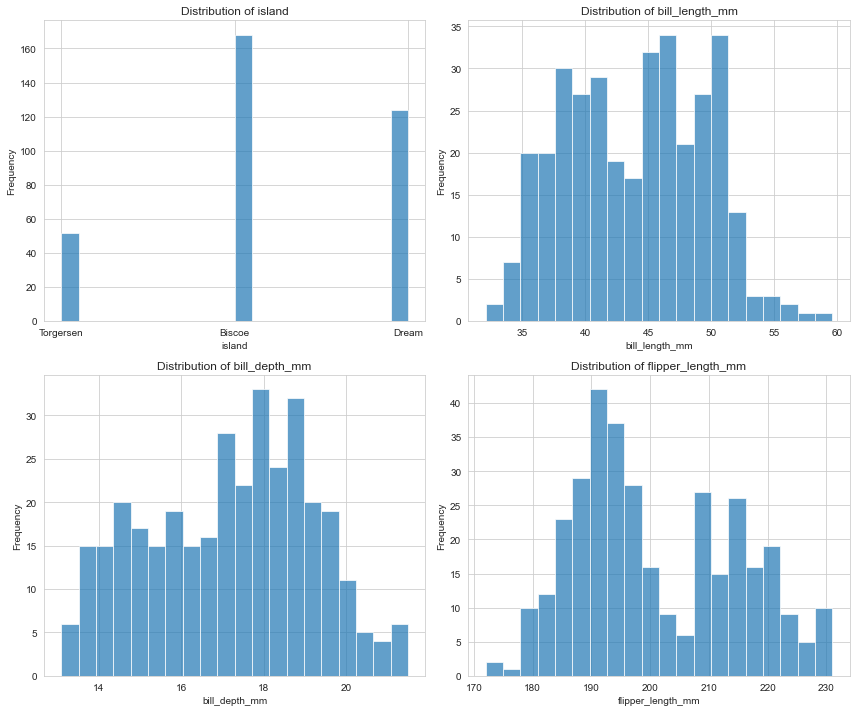

In [31]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

for idx, col in enumerate(df.columns[:4]):  # Adjust based on your features
    axes[idx].hist(df[col], bins=20, alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

A pairplot is a great tool that creates scatterplots for every pair of numerical features in our dataset.

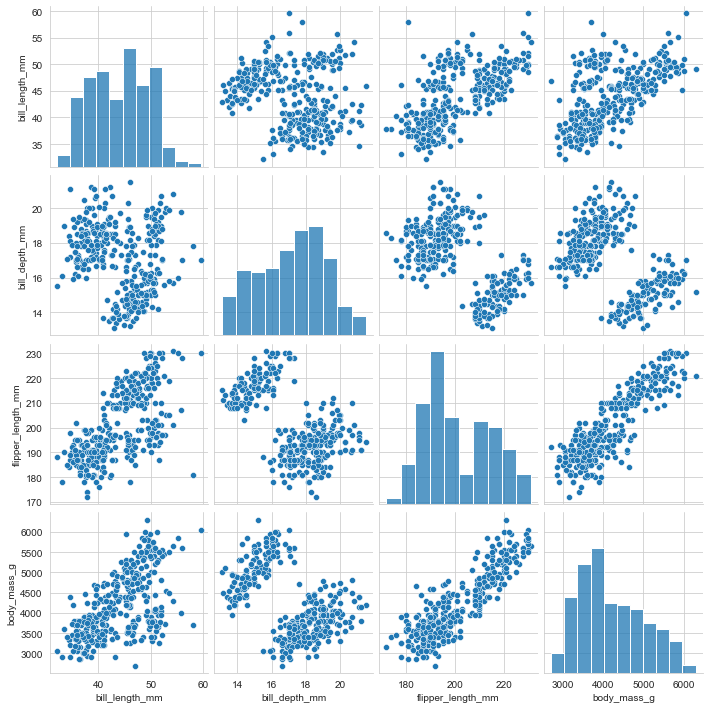

In [35]:
sns.pairplot(df_clean)
plt.show()

#### **Think About It (Discussion Questions):**

1.  Looking at the plots, do the three species of penguins seem to have different measurements? 
2.  Which two measurements seem to be the most effective at separating the species into distinct clusters? (Hint: Look for the plots where the colors are most separated).

## 4. Preparing the Data for Clustering

Machine learning models work with numbers, so we need to make sure our data is ready.

1.  **Select Features:** We will choose the columns (features) we want to use for clustering.

2.  **Scale the Features:** K-means works by measuring distances. We use `StandardScaler` to scale our features so they have a similar numerical range.

In [60]:
# Select the features for clustering
features = df[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]

imputer = SimpleImputer(strategy='mean')

# 3. Fit and transform the data
# The imputer learns the means from the columns and fills the NaNs.
# The output is a NumPy array.
imputed_features = imputer.fit_transform(features)


# Scale the features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(imputed_features)
features_scaled

array([[-0.88708123,  0.78774251, -1.42248782, -0.56578921],
       [-0.81349399,  0.12655633, -1.06535169, -0.50316788],
       [-0.66631952,  0.43171918, -0.42250666, -1.19200251],
       ...,
       [ 1.1917582 , -0.73807176,  1.50602843,  1.93906399],
       [ 0.23512413, -1.19581604,  0.79175618,  1.25022936],
       [ 1.09977416, -0.53462985,  0.8631834 ,  1.50071468]])

In [61]:
nan_count = np.sum(np.isnan(features_scaled))

print(f"Number of NaN values: {nan_count}")

Number of NaN values: 0


In [64]:
inertia_values = []
k_range = range(1, 11)

for k in k_range:
    # FIX: Set n_init='auto' to use the modern default setting
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(features_scaled)
    inertia_values.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia_values, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

TypeError: '<=' not supported between instances of 'str' and 'int'

## 5. The K-Means Algorithm: How Does It Work?

Okay, we can see the clusters with our eyes. But how can a computer do it *without* the answer key? This is where K-Means comes in.

Imagine the data points on one of the scatter plots above, but all colored gray. Your task is to find the groups of species.

**K-Means follows a simple, iterative process:**

1.  **Choose 'k'**: First, we tell the algorithm how many clusters to look for. In our case, we know there are 3 species, so we'll choose **k=3**.
2.  **Initialize Centroids**: The algorithm randomly drops k (3) 'centroids' (think of them as virtual center-points) onto the plot.
3.  **Assign Clusters**: It then assigns every single data point (each penguin) to its nearest centroid. This forms the initial clusters.
4.  **Update Centroids**: Next, it calculates the new center of each cluster by finding the average position of all the points within it. It moves the centroid to this new center.
5.  **Repeat**: It repeats steps 3 and 4 over and over. With each iteration, the centroids move less and less, until they eventually settle in the center of their respective clusters.

The algorithm has now found the groups without ever knowing the actual species!

## 5. Applying K-Means to the Penguin Data

Let's run the algorithm. Based on the pairplot, `bill_length_mm` and `flipper_length_mm` seemed to separate the clusters well. Let's use those two features to start.

In [7]:
# Select the features we want to use for clustering
# We are using a list of column names to select data from our DataFrame
features = df_cleaned[['culmen_length_mm', 'culmen_length_mm']]

# Create a KMeans model instance
# n_clusters: This is our 'k'. We're looking for 3 species.
# n_init='auto': This runs the algorithm multiple times with different random starting centroids and picks the best result.
# random_state: This ensures that the random starting points are the same every time we run the code, making our results reproducible.
kmeans = KMeans(n_clusters=3, n_init='auto', random_state=42)

# Fit the model to our features
kmeans.fit(features)

# Get the cluster assignments (labels) for each penguin
predicted_labels = kmeans.labels_

# Add the predicted labels back to our cleaned DataFrame
df_cleaned['predicted_cluster'] = predicted_labels

# Let's look at the first few rows with the new column
df_cleaned.head()

TypeError: '<=' not supported between instances of 'str' and 'int'

## 6. Visualizing and Evaluating the Results

The algorithm has assigned each penguin to a cluster (0, 1, or 2). How did it do? Let's create a scatter plot just like before, but this time, we'll color the points using our **predicted clusters**.

In [ ]:
# Get the coordinates of the final cluster centers (the centroids)
centroids = kmeans.cluster_centers_

# Create a scatter plot
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_cleaned, x='bill_length_mm', y='flipper_length_mm', hue='predicted_cluster', palette='viridis', s=100, alpha=0.7)

# Plot the centroids on top
plt.scatter(centroids[:, 0], centroids[:, 1], s=300, c='red', marker='X', label='Centroids')

plt.title('K-Means Clustering of Penguins')
plt.xlabel('Bill Length (mm)')
plt.ylabel('Flipper Length (mm)')
plt.legend()
plt.show()

### How good was the result?

The plot above looks pretty good! The groups seem well-defined. But how does it compare to the *actual* species? Let's use a tool called a **cross-tabulation** to compare the true `species` column with our `predicted_cluster` column.

In [ ]:
# Create a cross-tabulation to compare true species with predicted clusters
ctab = pd.crosstab(df_cleaned['species'], df_cleaned['predicted_cluster'])

print("Comparison of True Species vs. Predicted Clusters:")
print(ctab)

#### **Interpreting the Results (Discussion Questions):**

1.  Look at the table above. The rows are the true species, and the columns are the clusters the algorithm created. 
2.  How many 'Adelie' penguins were put into cluster 0? How many were put into other clusters?
3.  Which species was the algorithm most successful at identifying? 
4.  Where did the algorithm get confused? (Hint: look for rows where the numbers are spread across multiple columns).
5.  Overall, do you think the algorithm did a good job of rediscovering the species based only on bill and flipper length?

## 7. The Big Reveal: Validating with Species Labels

Now for the exciting part. Our original dataset *did* have the actual species for each penguin. We can now use these labels to see how well our algorithm's discovered clusters match the known biological species.

Let's create a table that compares the cluster assignment to the actual species.

In [ ]:
# First, we need to add the original species column to our cleaned data
# We use the index of 'features_clean' to select the correct rows from the original 'df'
validation_df = features_clean.copy()
validation_df['species'] = df.loc[features_clean.index, 'species']

# Create a crosstab to compare clusters and species
crosstab = pd.crosstab(validation_df['cluster'], validation_df['species'])
print(crosstab)

**Final Analysis:**
- Look at the table. Does each cluster primarily correspond to a single species?
- How successful was the K-means algorithm at discovering the different penguin species without being told about them?
- This process demonstrates the power of unsupervised learning: we can find meaningful structure in data and then use domain knowledge (in this case, biology) to interpret and validate that structure.

## 7. Challenge: Can We Do Better?

What do you think would happen if we gave the algorithm more information? Let's try running K-Means again, but this time, we'll use all four numerical measurements.

**Your task:** Complete the code below to run the clustering with all four features and then generate a new cross-tabulation to see if the results improved.

In [ ]:
# --- Your Code Here ---

# 1. Select all four numerical features
features_all = df_cleaned[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']]

# 2. Create and fit a new KMeans model
kmeans_all = KMeans(n_clusters=3, n_init='auto', random_state=42)
kmeans_all.fit(features_all)

# 3. Get the new predicted labels
predicted_labels_all = kmeans_all.labels_

# 4. Create a new cross-tabulation to compare
ctab_all = pd.crosstab(df_cleaned['species'], predicted_labels_all)

print("Comparison using all four features:")
print(ctab_all)

#### **Final Thoughts (Discussion Questions):**

1.  Compare the new table with the first one. Did using more data help the algorithm better separate the species? In what ways?
2.  Why can't we easily make a 2D scatter plot of these new results? (Hint: How many features did we use?)
3.  Congratulations! You've just performed machine learning. You used an algorithm to find patterns in data and make predictions—in this case, classifying penguins into groups that closely match their biological species.